# Sistema de recomendación - Collaborative Filtering

Andrés Franco Zapata\
Juliana Ochoa Ramirez\
Juan Esteban Torres Marulanda

In [1]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Sports_v1_00.tsv.gz

--2020-04-17 00:19:08--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Sports_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.135.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.135.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 872478735 (832M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Sports_v1_00.tsv.gz’

amazon_reviews_us_S 100%[===================>] 832.06M  16.5MB/s    in 53s     

2020-04-17 00:20:02 (15.6 MB/s) - ‘amazon_reviews_us_Sports_v1_00.tsv.gz’ saved [872478735/872478735]



In [2]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz

--2020-04-17 00:20:04--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475199894 (453M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Video_Games_v1_00.tsv.gz’

amazon_reviews_us_V 100%[===================>] 453.19M  16.8MB/s    in 29s     

2020-04-17 00:20:34 (15.6 MB/s) - ‘amazon_reviews_us_Video_Games_v1_00.tsv.gz’ saved [475199894/475199894]



In [3]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz

--2020-04-17 00:20:36--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.86.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.86.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27442648 (26M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz’

amazon_reviews_us_D 100%[===================>]  26.17M  9.66MB/s    in 2.7s    

2020-04-17 00:20:40 (9.66 MB/s) - ‘amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz’ saved [27442648/27442648]



In [0]:
!gzip -d amazon_reviews_us_Sports_v1_00.tsv.gz

In [0]:
!gzip -d amazon_reviews_us_Video_Games_v1_00.tsv.gz

In [0]:
!gzip -d amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz

In [7]:
!apt-get install openjdk-8-jdk -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)


In [8]:
!pip install pyspark

     |████████████████████████████████| 217.8MB 59kB/s 
     |████████████████████████████████| 204kB 46.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=19cddce851cecaf6e43b34f7cba58368a27011f26a987c9cc9c700c1d17ccbd7
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [9]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StructType, StructField, StringType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import lit, rand


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
ratings_df = pd.read_csv('amazon_reviews_us_Digital_Video_Games_v1_00.tsv', sep='\t', encoding='utf-8', error_bad_lines=False)

In [11]:
from sys import getsizeof

print(f'Size of data (in GB): {getsizeof(ratings_df)/(10**9)}')

Size of data (in GB): 0.160239893


#**Leer Datos** 

In [0]:
spark = SparkSession.builder\
       .appName("Simple recommendation engine using Spark MLlib")\
       .config("spark.some.config.option", "config-value")\
       .getOrCreate()

In [0]:
#sports_df = spark.read.csv("amazon_reviews_us_Sports_v1_00.tsv", sep='\t',header=True)
#games_df  = spark.read.csv("amazon_reviews_us_Video_Games_v1_00.tsv", sep='\t',header=True)

#ratings_df = sports_df.union(games_df)

ratings_df = spark.read.csv("amazon_reviews_us_Digital_Video_Games_v1_00.tsv", sep='\t',header=True)

In [14]:
print((ratings_df.count(), len(ratings_df.columns)))

(145431, 15)


In [15]:
ratings_df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [16]:
from sys import getsizeof

print(f'Size of data (in GB): {getsizeof(ratings_df)/(10**9)}')

print("In total there are {0} operations".format(ratings_df.count()))

Size of data (in GB): 5.6e-08
In total there are 145431 operations


In [17]:
ratings_df.select("customer_id",'review_id','product_id','product_title','product_category','star_rating','review_headline','review_body','review_date').show(5)

+-----------+--------------+----------+--------------------+-------------------+-----------+--------------------+--------------------+-----------+
|customer_id|     review_id|product_id|       product_title|   product_category|star_rating|     review_headline|         review_body|review_date|
+-----------+--------------+----------+--------------------+-------------------+-----------+--------------------+--------------------+-----------+
|   21269168| RSH1OZ87OYK92|B013PURRZW|Madden NFL 16 - X...|Digital_Video_Games|          2|A slight improvem...|I keep buying mad...| 2015-08-31|
|     133437|R1WFOQ3N9BO65I|B00F4CEHNK| Xbox Live Gift Card|Digital_Video_Games|          5|          Five Stars|             Awesome| 2015-08-31|
|   45765011| R3YOOS71KM5M9|B00DNHLFQA|Command & Conquer...|Digital_Video_Games|          5|Hail to the great...|If you are preppi...| 2015-08-31|
|     113118|R3R14UATT3OUFU|B004RMK5QG|Playstation Plus ...|Digital_Video_Games|          5|          Five Stars|     

#**Limpiar Datos** 

In [18]:
indexer_product_id = StringIndexer(inputCol="product_id", outputCol="product_new_id")
ratings_df = indexer_product_id.fit(ratings_df).transform(ratings_df)
 
ratings_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|   product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|product_new_id|
+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------+
|         US|   21269168| RSH1OZ87OYK92|B013PURRZW|     603406193|Madden NFL 16 - X...|Digital_Video_Games|          2|            2|          3|   N|                N|A slight improvem...|I keep buying mad...| 2015-08-31|        4686.0|
|         US|     133437|R1WFOQ3N9BO65I|B00F4CEH

In [19]:
ratings_df.registerTempTable("temp1")
query = """
SELECT 
  marketplace, 
  customer_id, 
  review_id, 
  product_id, 
  product_parent, 
  product_title, 
  product_category, 
  cast(star_rating as int) as star_rating, 
  helpful_votes, 
  total_votes, 
  vine, 
  verified_purchase, 
  review_headline, 
  review_body, 
  review_date,
  product_new_id
FROM temp1 as t1
where star_rating in (1,2,3,4,5,'1','2','3','4','5')
"""
ratings_df = spark.sql(query)
ratings_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|   product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|product_new_id|
+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------+
|         US|   21269168| RSH1OZ87OYK92|B013PURRZW|     603406193|Madden NFL 16 - X...|Digital_Video_Games|          2|            2|          3|   N|                N|A slight improvem...|I keep buying mad...| 2015-08-31|        4686.0|
|         US|     133437|R1WFOQ3N9BO65I|B00F4CEH

In [20]:
ratings_df.registerTempTable("temp2")
query = """
SELECT 
  cast(customer_id as int) as customer_id, 
  cast(product_new_id as int) as product_new_id,
  product_id,
  star_rating,
  product_title
FROM temp2 as t1
where cast(customer_id as int) is not null and
      cast(product_new_id as int) is not null and
      star_rating              is not null
"""
ratings_df = spark.sql(query)
ratings_df.show()

+-----------+--------------+----------+-----------+--------------------+
|customer_id|product_new_id|product_id|star_rating|       product_title|
+-----------+--------------+----------+-----------+--------------------+
|   21269168|          4686|B013PURRZW|          2|Madden NFL 16 - X...|
|     133437|            11|B00F4CEHNK|          5| Xbox Live Gift Card|
|   45765011|           190|B00DNHLFQA|          5|Command & Conquer...|
|     113118|             4|B004RMK5QG|          5|Playstation Plus ...|
|   22151364|          6557|B00G9BNLQE|          5|Saints Row IV - E...|
|   22151364|          2843|B00IMIL498|          5|Double Dragon: Ne...|
|   38426028|           231|B00S00IJH8|          4|              Sims 4|
|    6057518|             1|B004RMK4BC|          5|Playstation Netwo...|
|   20715661|            17|B00K59HKIQ|          5|Playstation Netwo...|
|   26540306|            17|B00K59HKIQ|          5|Playstation Netwo...|
|    8926809|            21|B004774IPU|          1|

In [21]:
print((ratings_df.count(), len(ratings_df.columns)))

(145431, 5)


# Análisis Descriptivo

In [22]:
ratings_df.registerTempTable("desc")
query_total_users = """
select count(distinct customer_id) as total_clientes
from desc
"""
print(spark.sql(query_total_users).show())

+--------------+
|total_clientes|
+--------------+
|        113405|
+--------------+

None


In [23]:
query_total_product = """
select count(distinct product_id) as total_productos
from desc
"""
print(spark.sql(query_total_product).show())

+---------------+
|total_productos|
+---------------+
|           7948|
+---------------+

None


In [24]:
query_user_rating = """
SELECT star_rating, count(*) as calif
FROM desc 
GROUP BY star_rating
ORDER BY star_rating DESC
"""

print(spark.sql(query_user_rating).show())

+-----------+-----+
|star_rating|calif|
+-----------+-----+
|          5|80677|
|          4|20406|
|          3|11629|
|          2| 7749|
|          1|24970|
+-----------+-----+

None


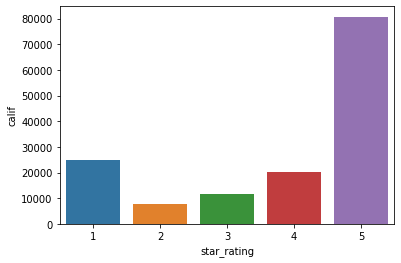

In [25]:
califications_pd = spark.sql(query_user_rating).toPandas()
sn.barplot(x="star_rating", y="calif",  data=califications_pd)

In [26]:
query_user_rating_total = """
SELECT customer_id, count(*) as reviews
FROM desc
GROUP BY customer_id
ORDER BY reviews DESC
"""

print(spark.sql(query_user_rating_total).show())

+-----------+-------+
|customer_id|reviews|
+-----------+-------+
|   21925455|     95|
|   40955995|     92|
|   23564949|     83|
|   52520442|     73|
|   14279279|     72|
|   51520185|     65|
|   20751317|     54|
|   50529050|     49|
|   25575022|     49|
|   11584162|     49|
|   39942708|     48|
|   36527466|     48|
|   31012456|     46|
|   52919259|     45|
|   46544620|     43|
|   19371429|     43|
|   53080901|     42|
|   26151231|     42|
|   45688707|     40|
|   14222166|     39|
+-----------+-------+
only showing top 20 rows

None


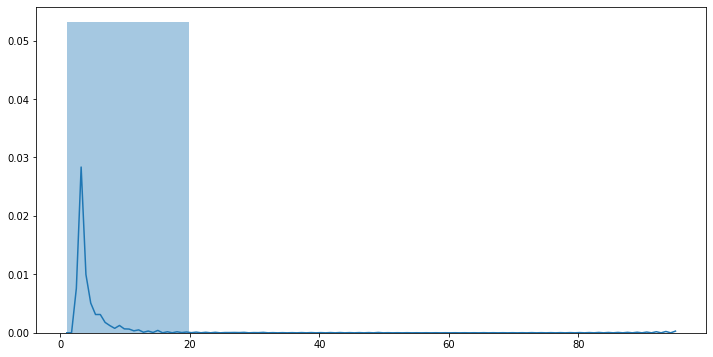

In [27]:
user_rating_pd = spark.sql(query_user_rating_total).toPandas()

plt.figure(figsize=(12, 6))
sn.distplot(user_rating_pd[['reviews']],bins=5)

# Latent Factor Model - alternating least squares (ALS) algorithm

In [28]:
(training, test) = ratings_df.randomSplit([0.8, 0.2])
training.cache()
test.cache()
training.show()

+-----------+--------------+----------+-----------+--------------------+
|customer_id|product_new_id|product_id|star_rating|       product_title|
+-----------+--------------+----------+-----------+--------------------+
|      10775|             2|B00GAC1D2G|          5|Playstation Netwo...|
|      11032|           817|B00SRZH210|          1|Life is Strange -...|
|      12739|            11|B00F4CEHNK|          5| Xbox Live Gift Card|
|      12752|           266|B00LLIQW20|          3|             Destiny|
|      12912|          1951|B00513EPMA|          5|Hidden Object Mov...|
|      13446|             2|B00GAC1D2G|          4|Playstation Netwo...|
|      13455|            42|B007W3ZZS0|          1|            Crysis 3|
|      14485|             2|B00GAC1D2G|          5|Playstation Netwo...|
|      14736|          1542|B001QFY7XO|          4|Westward III: Gol...|
|      14779|             2|B00GAC1D2G|          5|Playstation Netwo...|
|      15311|           843|B00ATF5YY8|          3|

In [29]:
from time import time

start_time = time()

als = ALS(userCol="customer_id", itemCol="product_new_id", ratingCol="star_rating",
          coldStartStrategy="drop", nonnegative=True) #rank=10, maxIter=10, regParam=0.1
model = als.fit(training)

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)



Elapsed time: 14.5371332169 seconds.


In [30]:
start_time = time()

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

Root-mean-square error = 1.824152668773879
Elapsed time: 15.3404986858 seconds.


In [31]:
predictions.show()

+-----------+--------------+----------+-----------+--------------------+----------+
|customer_id|product_new_id|product_id|star_rating|       product_title|prediction|
+-----------+--------------+----------+-----------+--------------------+----------+
|   15230828|           148|B0053YQ8E0|          4|Alice: Madness Re...| 1.1158329|
|   43063563|           148|B0053YQ8E0|          5|Alice: Madness Re...|  3.923602|
|    5685484|           148|B0053YQ8E0|          5|Alice: Madness Re...| 4.2215285|
|   47028076|           148|B0053YQ8E0|          3|Alice: Madness Re...| 2.8530567|
|   13151579|           148|B0053YQ8E0|          5|Alice: Madness Re...|0.66751516|
|   35480335|           148|B0053YQ8E0|          4|Alice: Madness Re...|   5.08541|
|   15355503|           148|B0053YQ8E0|          5|Alice: Madness Re...|  3.319488|
|   33598538|           148|B0053YQ8E0|          2|Alice: Madness Re...|  3.296199|
|   23651141|           148|B0053YQ8E0|          1|Alice: Madness Re...| 2.2

In [0]:
def train_ALS(train, test, reg_param, ranks):
  # initial
  min_error = float('inf')
  best_rank = -1
  best_regularization = 0
  best_model = None
  for rank in ranks:
    for reg in reg_param:
      als = ALS(maxIter=20, rank=rank, regParam=reg, userCol="customer_id", itemCol="product_new_id", ratingCol="star_rating", coldStartStrategy="drop", nonnegative=True)
      model = als.fit(train)
      predictions = model.transform(test)
      evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="prediction")
      error = evaluator.evaluate(predictions)
      print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
      if error < min_error:
        min_error = error
        best_rank = rank
        best_regularization = reg
        best_model = model
  print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
  return best_model

In [0]:
# hyper-param config
ranks = [2,4,6,8,10]
reg_params = [0.1,0.2,0.3,0.4,0.5]

In [34]:
start_time = time()

final_model = train_ALS(training, test, reg_params, ranks)

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

2 latent factors and regularization = 0.1: validation RMSE is 1.6749544824173233
2 latent factors and regularization = 0.2: validation RMSE is 1.6000418773857932
2 latent factors and regularization = 0.3: validation RMSE is 1.570897199613236
2 latent factors and regularization = 0.4: validation RMSE is 1.5594545845923358
2 latent factors and regularization = 0.5: validation RMSE is 1.561067396730267
4 latent factors and regularization = 0.1: validation RMSE is 1.6811378970247768
4 latent factors and regularization = 0.2: validation RMSE is 1.6050430296458644
4 latent factors and regularization = 0.3: validation RMSE is 1.5742144488896008
4 latent factors and regularization = 0.4: validation RMSE is 1.5642516340530195
4 latent factors and regularization = 0.5: validation RMSE is 1.5664055178647265
6 latent factors and regularization = 0.1: validation RMSE is 1.694527457041636
6 latent factors and regularization = 0.2: validation RMSE is 1.613256186824631
6 latent factors and regularizat

In [0]:
def plot_learning_curve(train, test, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    arr_iters = [i for i in range(1,20,2)]
    errors = []
    for num_iters in arr_iters:
      als = ALS(maxIter=num_iters, rank=rank, regParam=reg, userCol="customer_id", itemCol="product_new_id", ratingCol="star_rating", coldStartStrategy="drop", nonnegative=True)
      model = als.fit(train)
      predictions = model.transform(test)
      evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="prediction")
      error = evaluator.evaluate(predictions)
      errors.append(error)
    
    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

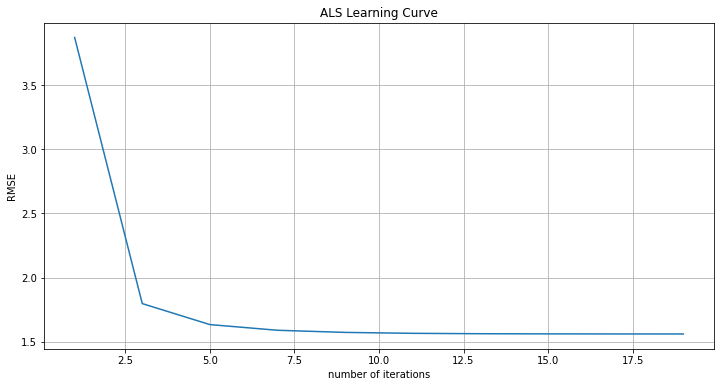

In [36]:
plot_learning_curve(training, test, 0.4, 2)

In [0]:
als = ALS(maxIter=20, rank=2, regParam=0.4, userCol="customer_id", itemCol="product_new_id", ratingCol="star_rating",
          coldStartStrategy="drop", nonnegative=True)
model = als.fit(training)

In [38]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.5594545845923358


# Extending Latent Factor Model to Include Biases

In [0]:
ratings_df.registerTempTable("temp3")

query = """
with general as (
  SELECT AVG(star_rating) as promedio_general
  FROM temp3
), 
promedio_cliente as (
  SELECT customer_id, avg(star_rating)  as b_userbias
  FROM temp3
  GROUP BY customer_id
),
promedio_item as (
  SELECT product_id, avg(star_rating) as b_itembias
  FROM temp3
  GROUP BY product_id
),
diff_promedio_cliente as (
  SELECT customer_id, b_userbias, b_userbias-promedio_general as b_userbias_diff
  FROM promedio_cliente
  CROSS JOIN general
),
diff_promedio_item as (
  SELECT product_id, b_itembias, b_itembias-promedio_general as b_itembias_diff
  FROM promedio_item
  CROSS JOIN general
)
SELECT 
  t1.customer_id,
  t1.product_new_id,
  t1.product_id,
  t1.product_title,
  t1.star_rating,
  t2.promedio_general,
  t3.b_userbias,
  t3.b_userbias_diff,
  t4.b_itembias,
  t4.b_itembias_diff,
  (t1.star_rating - t2.promedio_general - t3.b_userbias_diff - t4.b_itembias_diff) as new_star_rating
FROM temp3 as t1
CROSS JOIN general as t2
INNER JOIN diff_promedio_cliente as t3
  ON t1.customer_id = t3.customer_id
INNER JOIN diff_promedio_item as t4
  ON t1.product_id = t4.product_id
where   
  t2.promedio_general is not null and
  t3.b_userbias is not null and 
  t4.b_itembias is not null 
"""

In [40]:
ratings_df = spark.sql(query)
ratings_df.show()

+-----------+--------------+----------+--------------------+-----------+------------------+------------------+--------------------+------------------+--------------------+--------------------+
|customer_id|product_new_id|product_id|       product_title|star_rating|  promedio_general|        b_userbias|     b_userbias_diff|        b_itembias|     b_itembias_diff|     new_star_rating|
+-----------+--------------+----------+--------------------+-----------+------------------+------------------+--------------------+------------------+--------------------+--------------------+
|   51137709|          6325|B001KC02UA|Happy Hour! [Down...|          3|3.8531262248076406|               3.0| -0.8531262248076406|               3.0| -0.8531262248076406|  0.8531262248076406|
|   30130528|          3362|B002FGU06Q|Tradewinds Odysse...|          5|3.8531262248076406|               3.0| -0.8531262248076406|               3.6|-0.25312622480764047|  2.2531262248076405|
|   50912785|          3362|B002FGU

In [41]:
(training, test) = ratings_df.randomSplit([0.8, 0.2])
training.show()

+-----------+--------------+----------+--------------------+-----------+------------------+----------+-------------------+------------------+--------------------+--------------------+
|customer_id|product_new_id|product_id|       product_title|star_rating|  promedio_general|b_userbias|    b_userbias_diff|        b_itembias|     b_itembias_diff|     new_star_rating|
+-----------+--------------+----------+--------------------+-----------+------------------+----------+-------------------+------------------+--------------------+--------------------+
|      33322|            58|B005Q1YA5O|    The Sims 3: Pets|          1|3.8531262248076406|       1.0|-2.8531262248076406|3.4899598393574296|-0.36316638545021096| 0.36316638545021096|
|     223094|            45|B00F4CFBUS| Xbox Live Gift Card|          5|3.8531262248076406|       5.0| 1.1468737751923594| 4.608695652173913|  0.7555694273662725| -0.7555694273662725|
|     275563|            45|B00F4CFBUS| Xbox Live Gift Card|          5|3.853126

In [0]:
def train_ALS(train, test, reg_param, ranks):
  # initial
  min_error = float('inf')
  best_rank = -1
  best_regularization = 0
  best_model = None
  for rank in ranks:
    for reg in reg_param:
      als = ALS(maxIter=20, rank=rank, regParam=reg, userCol="customer_id", itemCol="product_new_id", ratingCol="new_star_rating", coldStartStrategy="drop", nonnegative=True)
      model = als.fit(train)
      predictions = model.transform(test)
      predictions= predictions.withColumn("predict", predictions.prediction + 
                                               predictions.promedio_general + 
                                               predictions.b_userbias_diff +
                                               predictions.b_itembias_diff)
      evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="predict")
      error = evaluator.evaluate(predictions)
      print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
      if error < min_error:
        min_error = error
        best_rank = rank
        best_regularization = reg
        best_model = model
  print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
  return best_model

In [43]:
# hyper-param config
ranks = [2,4,6,8,10]
reg_params = [0.1,0.2,0.3,0.4,0.5]

start_time = time()

final_model = train_ALS(training, test, reg_params, ranks)

elapsed_time = time() - start_time

print("Elapsed time: %.10f seconds." % elapsed_time)


2 latent factors and regularization = 0.1: validation RMSE is 1.0622673709323527
2 latent factors and regularization = 0.2: validation RMSE is 1.019733821029138
2 latent factors and regularization = 0.3: validation RMSE is 0.9997776050308512
2 latent factors and regularization = 0.4: validation RMSE is 0.9899768961802369
2 latent factors and regularization = 0.5: validation RMSE is 0.985451852361378
4 latent factors and regularization = 0.1: validation RMSE is 1.0407180346583296
4 latent factors and regularization = 0.2: validation RMSE is 1.004436058632076
4 latent factors and regularization = 0.3: validation RMSE is 0.9907798661421244
4 latent factors and regularization = 0.4: validation RMSE is 0.9838454661427648
4 latent factors and regularization = 0.5: validation RMSE is 0.9810211572888687
6 latent factors and regularization = 0.1: validation RMSE is 1.0163082081596055
6 latent factors and regularization = 0.2: validation RMSE is 0.9950906176754202
6 latent factors and regulariza

In [0]:
def plot_learning_curve(train, test, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    arr_iters = [i for i in range(1,20,2)]
    errors = []
    for num_iters in arr_iters:
      als = ALS(maxIter=num_iters, rank=rank, regParam=reg, userCol="customer_id", itemCol="product_new_id", ratingCol="new_star_rating", coldStartStrategy="drop", nonnegative=True)
      model = als.fit(train)
      predictions = model.transform(test)
      predictions= predictions.withColumn("predict", predictions.prediction + 
                                          predictions.promedio_general + 
                                          predictions.b_userbias_diff +
                                          predictions.b_itembias_diff)
      evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="predict")
      error = evaluator.evaluate(predictions)
      errors.append(error)
    
    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

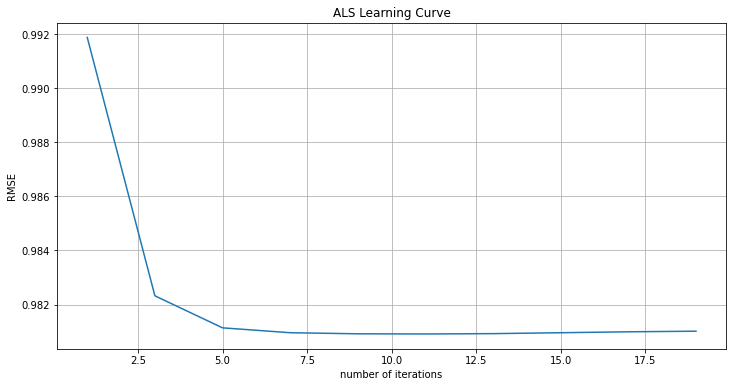

In [45]:
plot_learning_curve(training, test, 0.5, 8)

In [0]:
als = ALS(rank=10,maxIter=20, regParam=0.5, userCol="customer_id", itemCol="product_new_id", ratingCol="new_star_rating",coldStartStrategy="drop",nonnegative=False)
model = als.fit(training)

In [0]:
predictions = model.transform(test)

In [48]:
predictions.show(3)

+-----------+--------------+----------+--------------------+-----------+------------------+----------+--------------------+------------------+-------------------+-------------------+-------------+
|customer_id|product_new_id|product_id|       product_title|star_rating|  promedio_general|b_userbias|     b_userbias_diff|        b_itembias|    b_itembias_diff|    new_star_rating|   prediction|
+-----------+--------------+----------+--------------------+-----------+------------------+----------+--------------------+------------------+-------------------+-------------------+-------------+
|   43063563|           148|B0053YQ8E0|Alice: Madness Re...|          5|3.8531262248076406|      4.75|  0.8968737751923594|3.2755905511811023|-0.5775356736265382| 0.8275356736265382| 0.0031975345|
|   35587397|           148|B0053YQ8E0|Alice: Madness Re...|          5|3.8531262248076406|       5.0|  1.1468737751923594|3.2755905511811023|-0.5775356736265382| 0.5775356736265382| 0.0012999082|
|   47028076|  

In [0]:
predictions= predictions.withColumn("predict", predictions.prediction + 
                                               predictions.promedio_general + 
                                               predictions.b_userbias_diff +
                                               predictions.b_itembias_diff)

In [50]:
predictions.show()

+-----------+--------------+----------+--------------------+-----------+------------------+------------------+--------------------+------------------+--------------------+--------------------+-------------+------------------+
|customer_id|product_new_id|product_id|       product_title|star_rating|  promedio_general|        b_userbias|     b_userbias_diff|        b_itembias|     b_itembias_diff|     new_star_rating|   prediction|           predict|
+-----------+--------------+----------+--------------------+-----------+------------------+------------------+--------------------+------------------+--------------------+--------------------+-------------+------------------+
|   43063563|           148|B0053YQ8E0|Alice: Madness Re...|          5|3.8531262248076406|              4.75|  0.8968737751923594|3.2755905511811023| -0.5775356736265382|  0.8275356736265382| 0.0031975345| 4.175661860848937|
|   35587397|           148|B0053YQ8E0|Alice: Madness Re...|          5|3.8531262248076406|     

In [51]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating",
                                predictionCol="predict")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9857256609303019


# Recomendar Productos


In [0]:
def recomendar_productos(model, all_prod, customer, num_recom=5):
  user = ratings_df.where(ratings_df.customer_id == customer).select("customer_id","product_new_id", "product_title")
  all_prod = all_prod.withColumn("customer_id", lit(customer))
  #se restan los productos de user al total de peliculas
  productos = all_prod.subtract(user)
  productos = productos.withColumn("customer_id", productos.customer_id.cast("int"))
  recomendaciones = model.transform(productos)
  recomendaciones.orderBy('prediction', ascending=False).limit(num_recom).show()

In [0]:
ratings_df.registerTempTable("temp3")

query = """
  select distinct product_new_id, product_title
  from temp3
"""
all_prod = spark.sql(query)
#all_prod.show()

In [64]:
from pyspark.sql.functions import lit, rand
ratings_df.select('customer_id').orderBy(rand()).limit(3).collect()

[Row(customer_id=17993277),
 Row(customer_id=10271800),
 Row(customer_id=19910270)]

In [67]:
#recomendar_productos(model, all_prod, 36639795)
recomendar_productos(model, all_prod, 17993277,6)

+--------------+--------------------+-----------+----------+
|product_new_id|       product_title|customer_id|prediction|
+--------------+--------------------+-----------+----------+
|          6848|Tycoon City: New ...|   17993277|  0.536095|
|          5904|Sniper Elite 3 - ...|   17993277|0.48355195|
|          6556|Speak & Learn Eng...|   17993277|0.48092166|
|          5545|Blazing Angels Bu...|   17993277|0.47899956|
|          5663|Circus Empire [Do...|   17993277| 0.4788028|
|          3510|Star Raiders [Dow...|   17993277|0.47275764|
+--------------+--------------------+-----------+----------+



In [0]:
userRecs = model.recommendForAllUsers(5)

In [0]:
recom=userRecs.where(userRecs.customer_id == 36639795).select("recommendations.product_id", "recommendations.rating").collect()
recom.show()